In [43]:
import json
import os

import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer

In [44]:
cache_dir = 'cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

json_path = '../data/arxiv-metadata-oai-snapshot.json'
if not os.path.exists(json_path):
    raise FileNotFoundError(f"Please download the arXiv metadata from {json_path}")

load_existing = True
parquet_path = '../data/arxiv_metadata.parquet.gzip'


category_map_path = '../data/category_map.json'

## Process json

In [45]:
# load json into pandas dataframe in chunks and only keep the relevant columns
if load_existing and os.path.exists(parquet_path):
    print(f"Loading existing parquet file from {parquet_path}")
    data_df = pd.read_parquet(parquet_path, engine='pyarrow')
    display(data_df.head(2), data_df.tail(2))
    print(f"Loaded {len(data_df)} rows")
else:
    columns_to_keep = ['id', 'title', 'abstract', 'categories', 'update_date']
    dtypes = {'id': str, 'title': str, 'abstract': str, 'categories': str, 'update_date': str}
    chunksize = 100_000
    reader = pd.read_json(json_path, lines=True, chunksize=chunksize)

    data_to_keep = []
    for i, chunk in enumerate(reader):
        print(f"Processing chunk {i} - so far {len(data_to_keep) * chunksize} rows")
        data_to_keep.append(chunk[columns_to_keep].to_dict(orient='records'))
    data_to_keep = [item for sublist in data_to_keep for item in sublist]
    new_df = pd.DataFrame(data_to_keep).reset_index(drop=True)
    for col in columns_to_keep:
        new_df[col] = new_df[col].astype(dtypes[col])
    del data_to_keep

    display(new_df.head(2), new_df.tail(2))

    new_df.to_parquet(parquet_path, compression='gzip', engine='pyarrow')

Loading existing parquet file from ../data/arxiv_metadata.parquet.gzip


,id,title,abstract,categories,update_date
0,704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph,2008-11-26
1,704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG,2008-12-13


,id,title,abstract,categories,update_date
2477301,supr-con/9609003,Density of States and NMR Relaxation Rate in A...,We show that the density of states in an ani...,supr-con cond-mat.supr-con,2009-10-30
2477302,supr-con/9609004,Ginzburg Landau theory for d-wave pairing and ...,The Ginzburg Landau theory for d_{x^2-y^2}-w...,supr-con cond-mat.supr-con,2009-10-30


Loaded 2477303 rows


## EDA

In [46]:
# https://arxiv.org/category_taxonomy
# categories_of_interest = [
#     "Astrophysics",
#     "Artificial Intelligence",
#     "Computer Vision and Pattern Recognition",
#     "Graphics",
#     "Information Retrieval",
#     "Machine Learning",
#     "Sound",
#     "Robotics",
#     "Audio and Speech Processing",
#     "Image and Video Processing",
#     "Portfolio Management",
#     "Space Physics",
#     "Genomics"
# ]
# categories_of_interest = [
#     "Machine Learning",
# ]
categories_of_interest = []
with open(category_map_path, 'r') as f:
    category_map = json.load(f)

In [47]:
data_df.head(3)

,id,title,abstract,categories,update_date
0,704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph,2008-11-26
1,704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG,2008-12-13
2,704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,physics.gen-ph,2008-01-13


In [48]:
data_df['title_words'] = data_df['title'].apply(lambda x: len(x.split()))
data_df['abstract_words'] = data_df['abstract'].apply(lambda x: len(x.split()))
data_df['categories'] = data_df['categories'].apply(lambda x: x.split())
data_df['mapped_categories'] = data_df['categories'].apply(lambda x: [category_map[cat] if cat in category_map else "UNKNOWN" for cat in x])
data_df['amount_categories'] = data_df['categories'].apply(lambda x: len(x))
data_df['update_year'] = data_df['update_date'].apply(lambda x: int(x[:4]))
data_df.head(3)

,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year
0,704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,[hep-ph],2008-11-26,12,140,[High Energy Physics - Phenomenology],1,2008
1,704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...","[math.CO, cs.CG]",2008-12-13,3,115,"[Combinatorics, Computational Geometry]",2,2008
2,704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,[physics.gen-ph],2008-01-13,14,144,[General Physics],1,2008


In [42]:
# # first of all filter out ids that are not set

# # id_regex = [max 4 numbers].[max 4 numbers]
# # if number is less than 4 digits, it can be padded with zeros on the left
# id_regex = r'\d{1,4}\.\d{1,4}'

# print(f'Before filtering: {len(data_df)}')
# data_df = data_df[data_df['id'].str.match(id_regex)]
# data_df['id'] = data_df['id'].apply(lambda x: '.'.join([f"{int(y):04d}" for y in x.split('.')]))
# print(f'After filtering: {len(data_df)}')
# data_df.value_counts('id').sort_values(ascending=False).head(3)

Before filtering: 2477303
After filtering: 2063182


id
1911.0001    5
1807.0001    5
2105.0001    5
Name: count, dtype: int64

In [49]:
print(f'Max number of words in title: {data_df["title_words"].max()}')
print(f'Max number of words in abstract: {data_df["abstract_words"].max()}')
print("-" * 50)
print(f'Min number of words in title: {data_df["title_words"].min()}')
print(f'Min number of words in abstract: {data_df["abstract_words"].min()}')
print("-" * 50)
print(f'Mean number of words in title: {data_df["title_words"].mean()}')
print(f'Mean number of words in abstract: {data_df["abstract_words"].mean()}')
print("-" * 50)
print(f'Median number of words in title: {data_df["title_words"].median()}')
print(f'Median number of words in abstract: {data_df["abstract_words"].median()}')

Max number of words in title: 61
Max number of words in abstract: 925
--------------------------------------------------
Min number of words in title: 1
Min number of words in abstract: 1
--------------------------------------------------
Mean number of words in title: 9.751281534798125
Mean number of words in abstract: 140.6586021168989
--------------------------------------------------
Median number of words in title: 9.0
Median number of words in abstract: 135.0


<Axes: xlabel='title_words', ylabel='Count'>

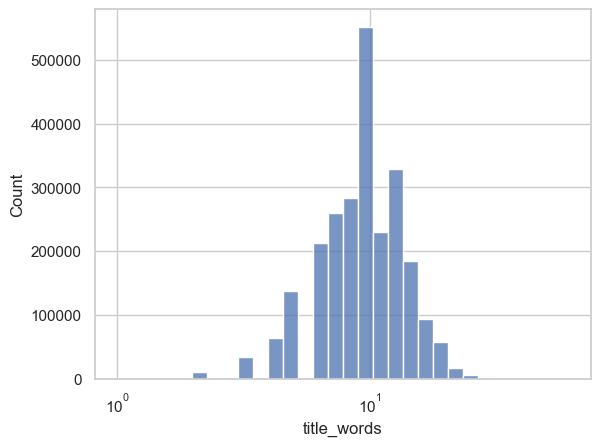

In [50]:
# histogram of number of words in titles and abstracts
sns.histplot(data_df['title_words'], bins=30, log_scale=True)

<Axes: xlabel='abstract_words', ylabel='Count'>

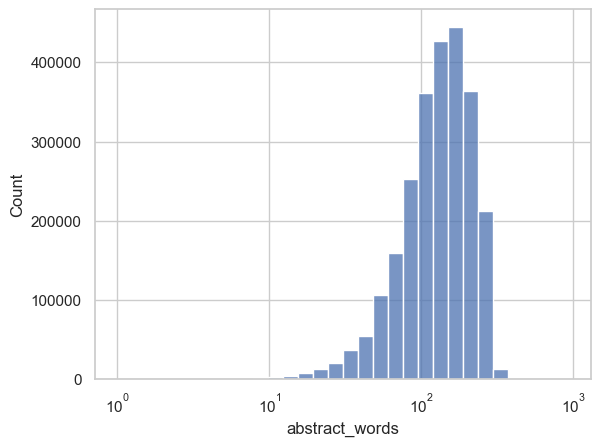

In [51]:
sns.histplot(data_df['abstract_words'], bins=30, log_scale=True)

In [52]:
abtract_words_dist = data_df['abstract_words'].value_counts().sort_values(ascending=False)
display(abtract_words_dist.head(3), abtract_words_dist.tail(3))
show_n = 10
for n in range(1, show_n + 1):
    print(f"Only {n} words in abstract: {abtract_words_dist[n]} times")

abstract_words
150    16475
100    15456
149    15417
Name: count, dtype: int64

abstract_words
497    1
487    1
458    1
Name: count, dtype: int64

Only 1 words in abstract: 4 times
Only 2 words in abstract: 31 times
Only 3 words in abstract: 43 times
Only 4 words in abstract: 66 times
Only 5 words in abstract: 246 times
Only 6 words in abstract: 110 times
Only 7 words in abstract: 218 times
Only 8 words in abstract: 427 times
Only 9 words in abstract: 386 times
Only 10 words in abstract: 531 times


In [53]:
# Lets look at examples of papers with just a few words in the abstract or title
data_df[data_df['abstract_words'] == 1].head(3)

,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year
766954,1609.01476,Can decay be ascribed to classical noise?,No.\n,"[quant-ph, math-ph, math.MP]",2017-05-10,7,1,"[Quantum Physics, Mathematical Physics, Mathem...",3,2017
1008542,1807.11336,Are theoretical results 'Results'?,Yes.\n,"[q-bio.OT, cond-mat.soft, physics.bio-ph]",2018-07-31,4,1,"[Other Quantitative Biology, Soft Condensed Ma...",3,2018
1083406,1902.02322,Is AmI (Attacks Meet Interpretability) Robust ...,No.\n,"[cs.LG, cs.AI, cs.CR, stat.ML]",2019-02-07,9,1,"[Machine Learning, Artificial Intelligence, Cr...",4,2019


In [54]:
# plot number of papers per year
data_df['update_year'].value_counts().sort_index()

update_year
2007    145833
2008     69325
2009    229015
2010     56175
2011     61794
2012     57222
2013     71838
2014     87847
2015    214639
2016    133303
2017    122202
2018    135646
2019    154632
2020    175299
2021    188606
2022    196471
2023    249061
2024    128395
Name: count, dtype: int64

[1] Machine Learning: 238909
[2] High Energy Physics - Phenomenology: 179237
[3] High Energy Physics - Theory: 165608
[4] Mathematical Physics: 157842
[5] Quantum Physics: 147273
[6] Computer Vision and Pattern Recognition: 122355
[7] General Relativity and Quantum Cosmology: 106566
[8] Astrophysics: 105380
[9] Information Theory: 92918
[10] Materials Science: 91373
[11] Mesoscale and Nanoscale Physics: 89416
[12] Artificial Intelligence: 88675
[13] Strongly Correlated Electrons: 73199
[14] Statistical Mechanics: 72906
[15] Cosmology and Nongalactic Astrophysics: 66729
[16] Combinatorics: 65317
[17] Astrophysics of Galaxies: 63450
[18] Computation and Language: 61702
[19] Analysis of PDEs: 61350
[20] Numerical Analysis: 60942
[21] Solar and Stellar Astrophysics: 59666
[22] High Energy Astrophysical Phenomena: 56943
[23] Nuclear Theory: 56804
[24] Probability: 55585
[25] Systems and Control: 54320
[26] High Energy Physics - Experiment: 53321
[27] Algebraic Geometry: 52036
[28] Optimizat

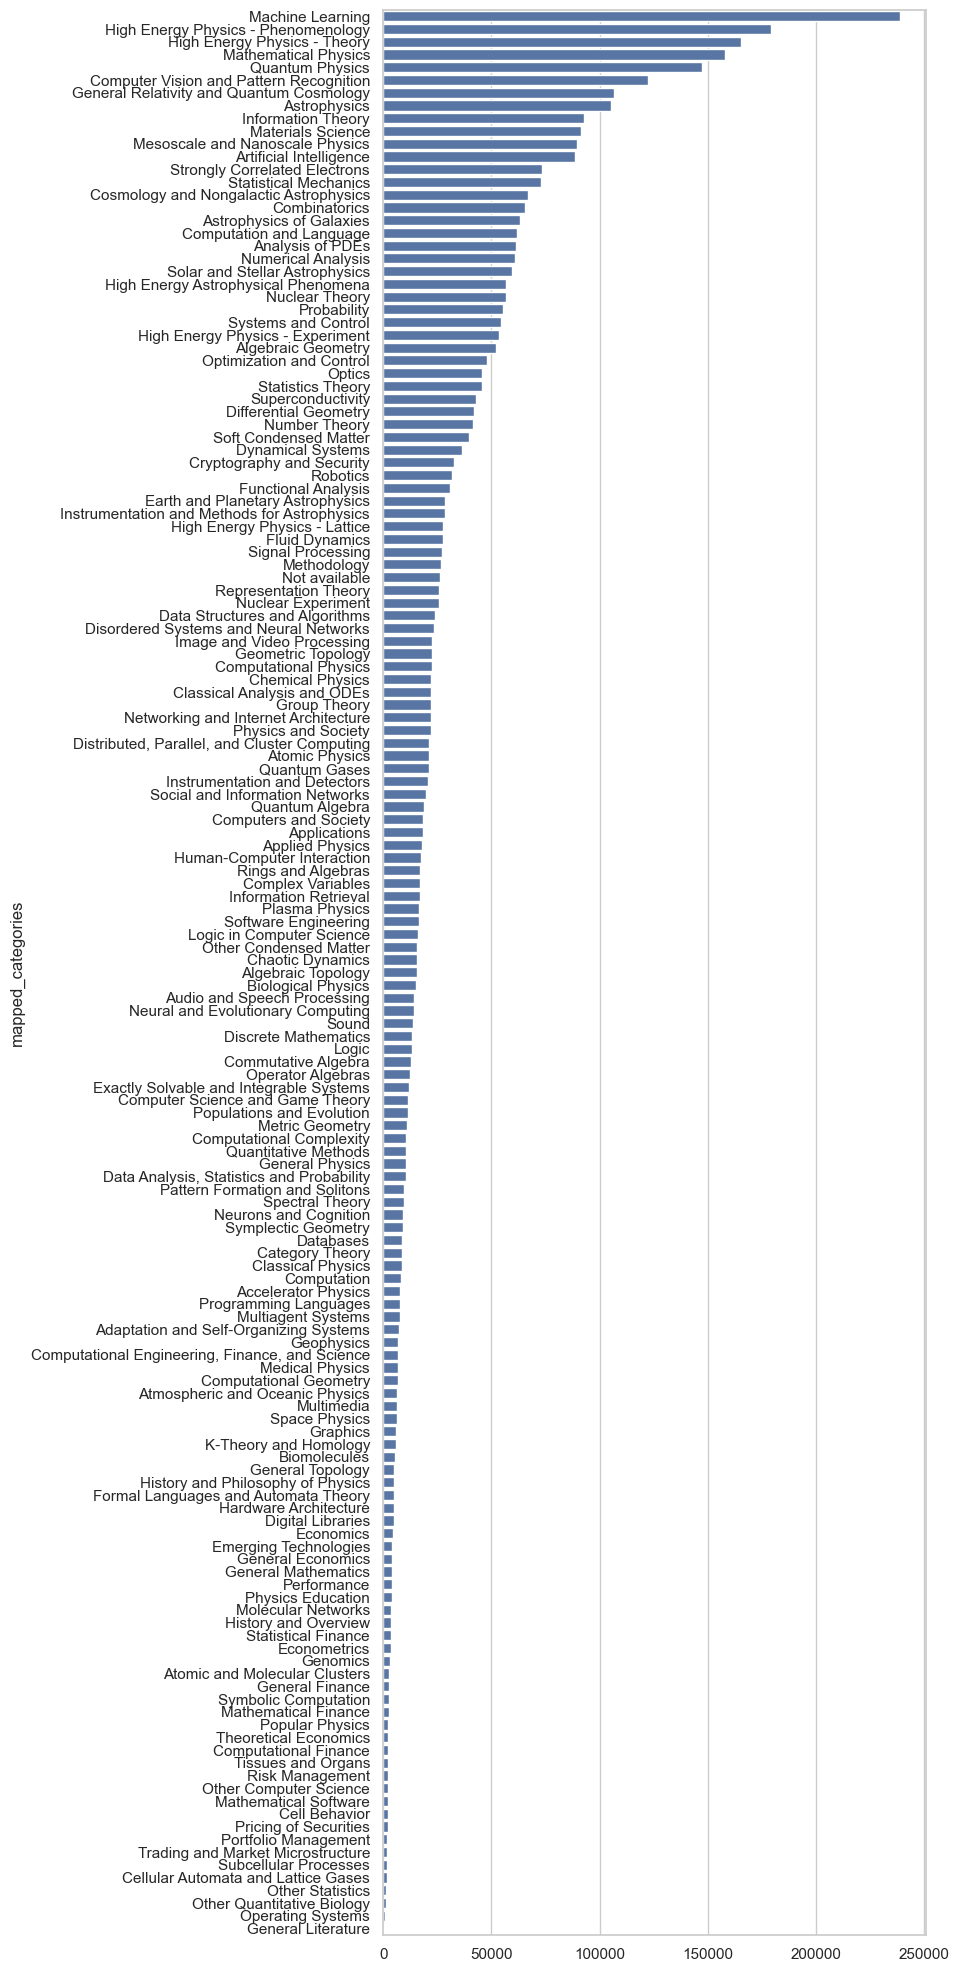

In [55]:
from matplotlib import pyplot as plt


def print_category_counts(data_df):
    category_counts = data_df['mapped_categories'].explode().value_counts().sort_values(ascending=False)
    for i, (cat, count) in enumerate(category_counts.items(), 1):
        print(f"[{i}] {cat}: {count}")
    print(f"Total categories: {len(category_counts)}")

def plot_category_counts(data_df, fig_size=(7, 25)):
    category_counts = data_df['mapped_categories'].explode().value_counts().sort_values(ascending=False)
    fig = plt.figure(figsize=fig_size)
    sns.set(style="whitegrid")
    sns.set_color_codes("pastel")
    sns.set_context("notebook")
    sns.barplot(y=category_counts.index, x=category_counts.values)

print_category_counts(data_df)
plot_category_counts(data_df)

In [56]:
def show_duplicates_in_category_map(df):
    category_counts = data_df['mapped_categories'].explode().value_counts().sort_values(ascending=False)
    unique_categories = category_counts.index.tolist()
    print(f"Unique categories: {len(unique_categories)}") # 151
    print(f"Total categories: {len(category_map.values())}") # 176


    # look which categories are twice in category_map
    category_map_values = list(category_map.values())
    duplicates = [x for x in category_map_values if category_map_values.count(x) > 1]
    print(f"Duplicate categories: {len(duplicates)}")
    print(duplicates)

show_duplicates_in_category_map(data_df)


# the category 'Not available' appears often and also other categories are duplicated (Machine Learning, ...)
# if papers have multiple same categories, we can remove the
data_df['mapped_categories'] = data_df['mapped_categories'].apply(lambda x: list(set(x)))

Unique categories: 151
Total categories: 176
Duplicate categories: 36
['Accelerator Physics', 'Not available', 'Not available', 'Not available', 'Not available', 'Not available', 'Not available', 'Not available', 'Not available', 'Not available', 'Not available', 'Not available', 'Not available', 'Not available', 'Atomic Physics', 'Chemical Physics', 'Plasma Physics', 'Not available', 'Not available', 'Not available', 'Systems and Control', 'Information Theory', 'Machine Learning', 'Numerical Analysis', 'Systems and Control', 'Information Theory', 'Mathematical Physics', 'Numerical Analysis', 'Statistics Theory', 'Mathematical Physics', 'Accelerator Physics', 'Atomic Physics', 'Chemical Physics', 'Plasma Physics', 'Machine Learning', 'Statistics Theory']


In [57]:
amount_categories_per_paper = data_df['amount_categories'].value_counts().sort_index()
for amount, count in amount_categories_per_paper.items():
    print(f"Paper with {amount} categories: {count}")

Paper with 1 categories: 1327729
Paper with 2 categories: 730544
Paper with 3 categories: 291723
Paper with 4 categories: 94134
Paper with 5 categories: 26452
Paper with 6 categories: 5685
Paper with 7 categories: 839
Paper with 8 categories: 147
Paper with 9 categories: 33
Paper with 10 categories: 14
Paper with 11 categories: 2
Paper with 13 categories: 1


In [58]:
# show the papers with the most categories
data_df[data_df['amount_categories'] == data_df['amount_categories'].max()]['mapped_categories'].values[0]

['Mathematical Physics',
 'Cryptography and Security',
 'Information Theory',
 'Probability',
 'Discrete Mathematics',
 'Group Theory',
 'Number Theory',
 'Representation Theory',
 'Quantum Algebra',
 'Symplectic Geometry',
 'Quantum Physics']

,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year
0,704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,[hep-ph],2008-11-26,12,140,[High Energy Physics - Phenomenology],1,2008
1,704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,[physics.gen-ph],2008-01-13,14,144,[General Physics],1,2008
2,704.0004,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,[math.CO],2007-05-23,11,35,[Combinatorics],1,2007


[1] Astrophysics: 86911
[2] High Energy Physics - Phenomenology: 81028
[3] Quantum Physics: 68611
[4] High Energy Physics - Theory: 58715
[5] Computer Vision and Pattern Recognition: 57192
[6] Materials Science: 39158
[7] Mesoscale and Nanoscale Physics: 34834
[8] Analysis of PDEs: 33933
[9] General Relativity and Quantum Cosmology: 30424
[10] Astrophysics of Galaxies: 30422
[11] Combinatorics: 29385
[12] Solar and Stellar Astrophysics: 26887
[13] Strongly Correlated Electrons: 26045
[14] Computation and Language: 23967
[15] Probability: 23579
[16] High Energy Astrophysical Phenomena: 22903
[17] Cosmology and Nongalactic Astrophysics: 21843
[18] Number Theory: 21835
[19] Algebraic Geometry: 20144
[20] Statistical Mechanics: 19503
[21] Nuclear Theory: 19279
[22] Machine Learning: 17920
[23] High Energy Physics - Experiment: 17635
[24] Optimization and Control: 17177
[25] Superconductivity: 16695
[26] Differential Geometry: 16216
[27] Optics: 16018
[28] Earth and Planetary Astrophysics: 

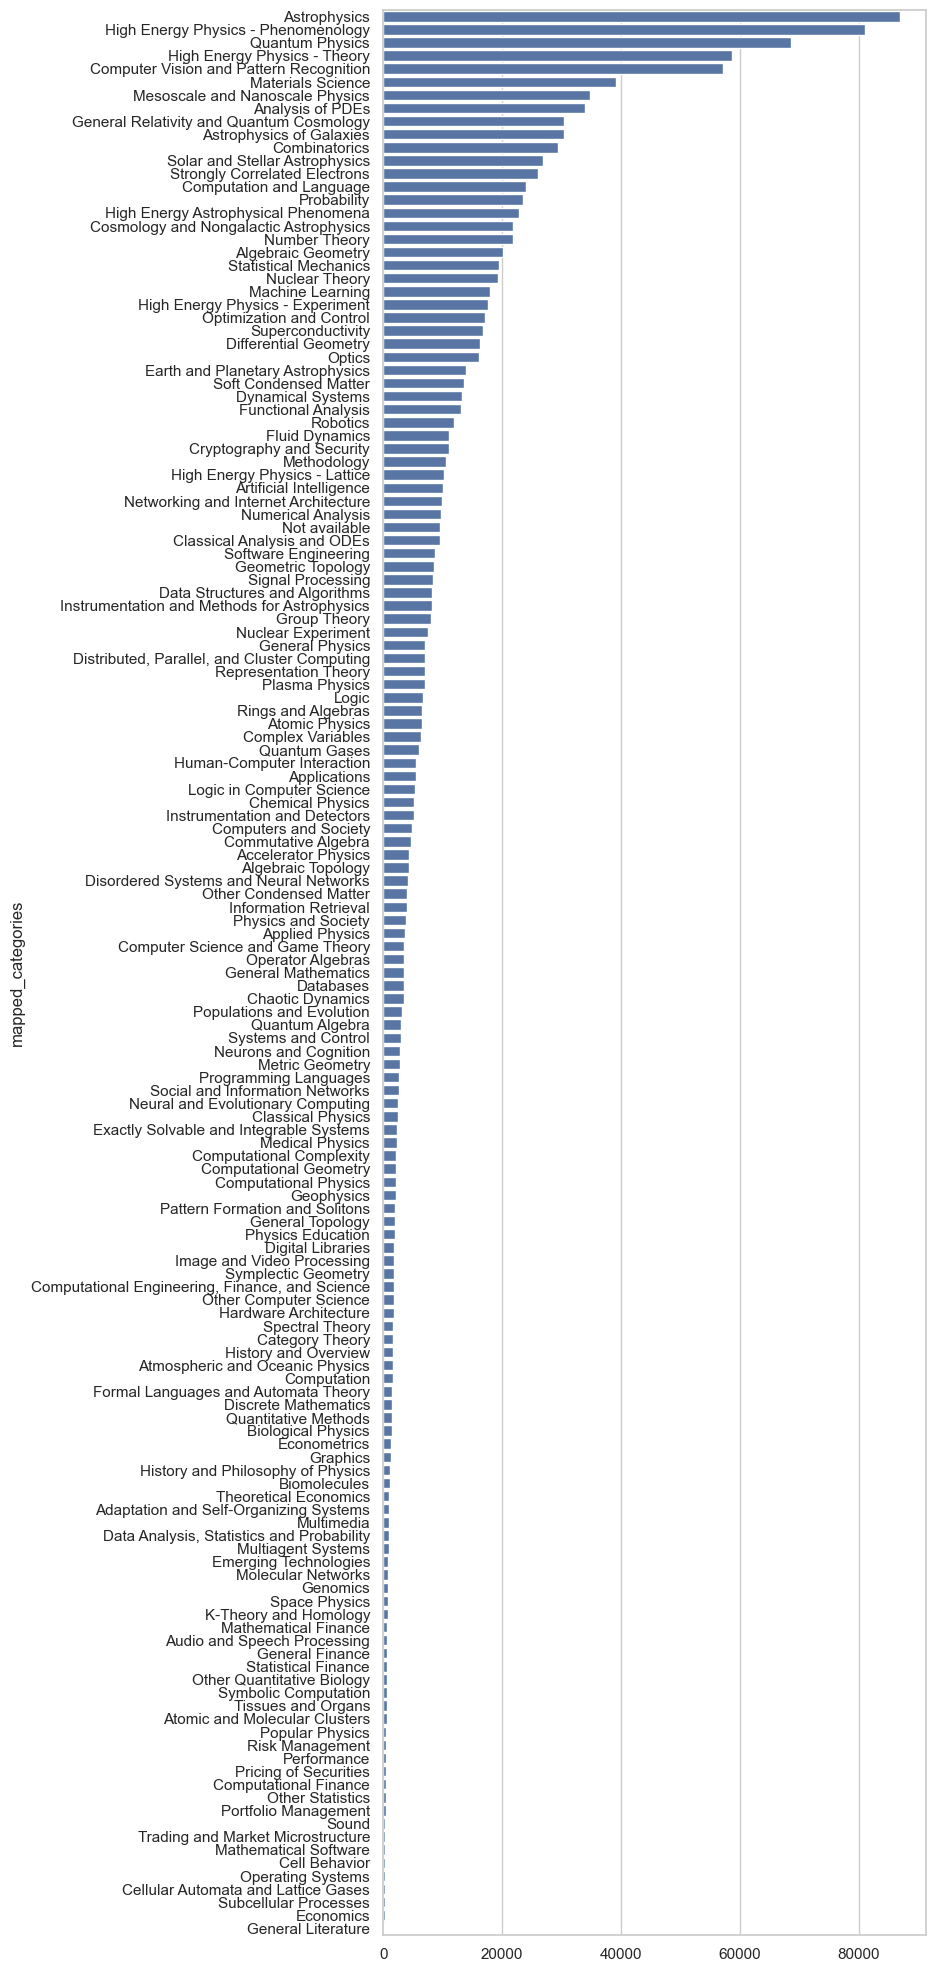

In [59]:
# for now just use papers with one category for simplicity for evaluation (clustering)
data_simple_df = data_df[data_df['amount_categories'] == 1].reset_index(drop=True)
display(data_simple_df.head(3))
# histogram for mapped categories (list of categories per paper)
print_category_counts(data_simple_df)
plot_category_counts(data_simple_df)

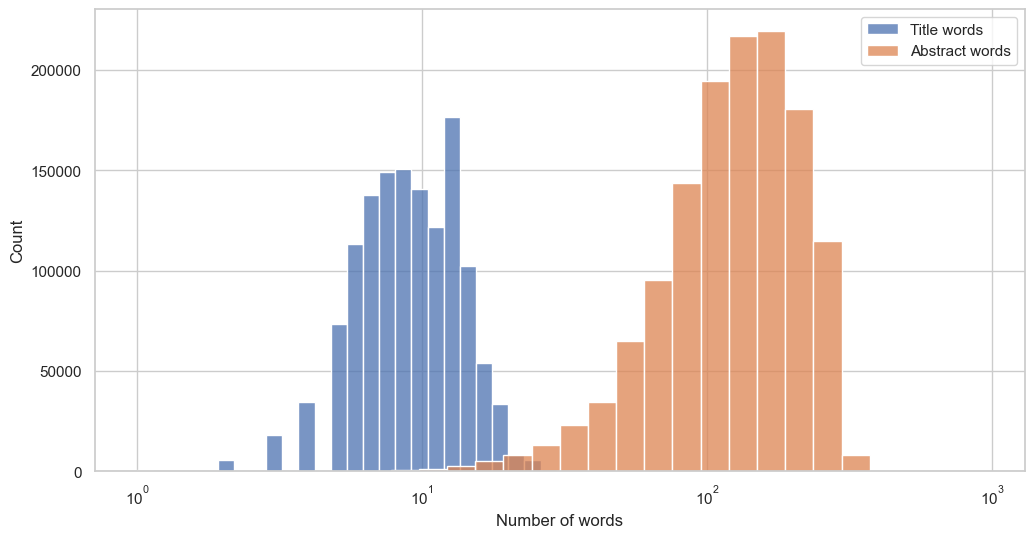

In [60]:
# Now again have a look at the distribution of the number of words in the abstracts and titles
plt.figure(figsize=(12, 6))
_ = sns.histplot(data_simple_df['title_words'], bins=30, log_scale=True, label='Title words')
_ = sns.histplot(data_simple_df['abstract_words'], bins=30, log_scale=True, label='Abstract words')
plt.legend()
plt.xlabel('Number of words')
plt.show()

In [61]:
# There are still some papers with very few words in the abstract / title
min_words_title = data_simple_df['title_words'].min()
min_words_abstract = data_simple_df['abstract_words'].min()
max_words_title = data_simple_df['title_words'].max()
max_words_abstract = data_simple_df['abstract_words'].max()
print(f"Min words in title: {min_words_title}")
print(f"Min words in abstract: {min_words_abstract}")
print(f"Max words in title: {max_words_title}")
print(f"Max words in abstract: {max_words_abstract}")

# show examples of papers with very few words in the title
display(data_simple_df[data_simple_df['title_words'] == min_words_title].head(3))
display(data_simple_df[data_simple_df['abstract_words'] == min_words_abstract].head(3))

# For now we will remove papers with less than 25p quantile of words in abstract and title and more than 75p quantile
title_quantiles = data_simple_df['title_words'].quantile(0.1), data_simple_df['title_words'].quantile(0.75)
abstract_quantiles = data_simple_df['abstract_words'].quantile(0.25), data_simple_df['abstract_words'].quantile(0.75)
print(f"Title quantiles: {title_quantiles}")
print(f"Abstract quantiles: {abstract_quantiles}")

# remove papers with less than 25p quantile of words in abstract and title and more than 75p quantile
data_clean_simple_df = data_simple_df[
    (data_simple_df['title_words'] >= title_quantiles[0]) & (data_simple_df['title_words'] <= title_quantiles[1]) &
    (data_simple_df['abstract_words'] >= abstract_quantiles[0]) & (data_simple_df['abstract_words'] <= abstract_quantiles[1])
].reset_index(drop=True)
print(f"Papers before cleaning: {len(data_simple_df)}")
print(f"Papers after cleaning: {len(data_clean_simple_df)}")

Min words in title: 1
Min words in abstract: 1
Max words in title: 50
Max words in abstract: 925


,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year
7437,706.2921,Herwig++,We describe the recent development of the He...,[hep-ph],2007-06-21,1,10,[High Energy Physics - Phenomenology],1,2007
7805,706.3479,Hypocomputation,"Hypercomputational formal theories will, cle...",[cs.OH],2011-11-10,1,143,[Other Computer Science],1,2011
11674,708.0295,Reliability,This special volume of Statistical Sciences ...,[stat.ME],2009-09-29,1,167,[Methodology],1,2009


,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year
932212,2303.11802,Could planet/sun conjunctions be used to predi...,No.\n,[physics.geo-ph],2023-03-23,10,1,[Geophysics],1,2023


Title quantiles: (6.0, 12.0)
Abstract quantiles: (87.0, 182.0)
Papers before cleaning: 1327729
Papers after cleaning: 472237


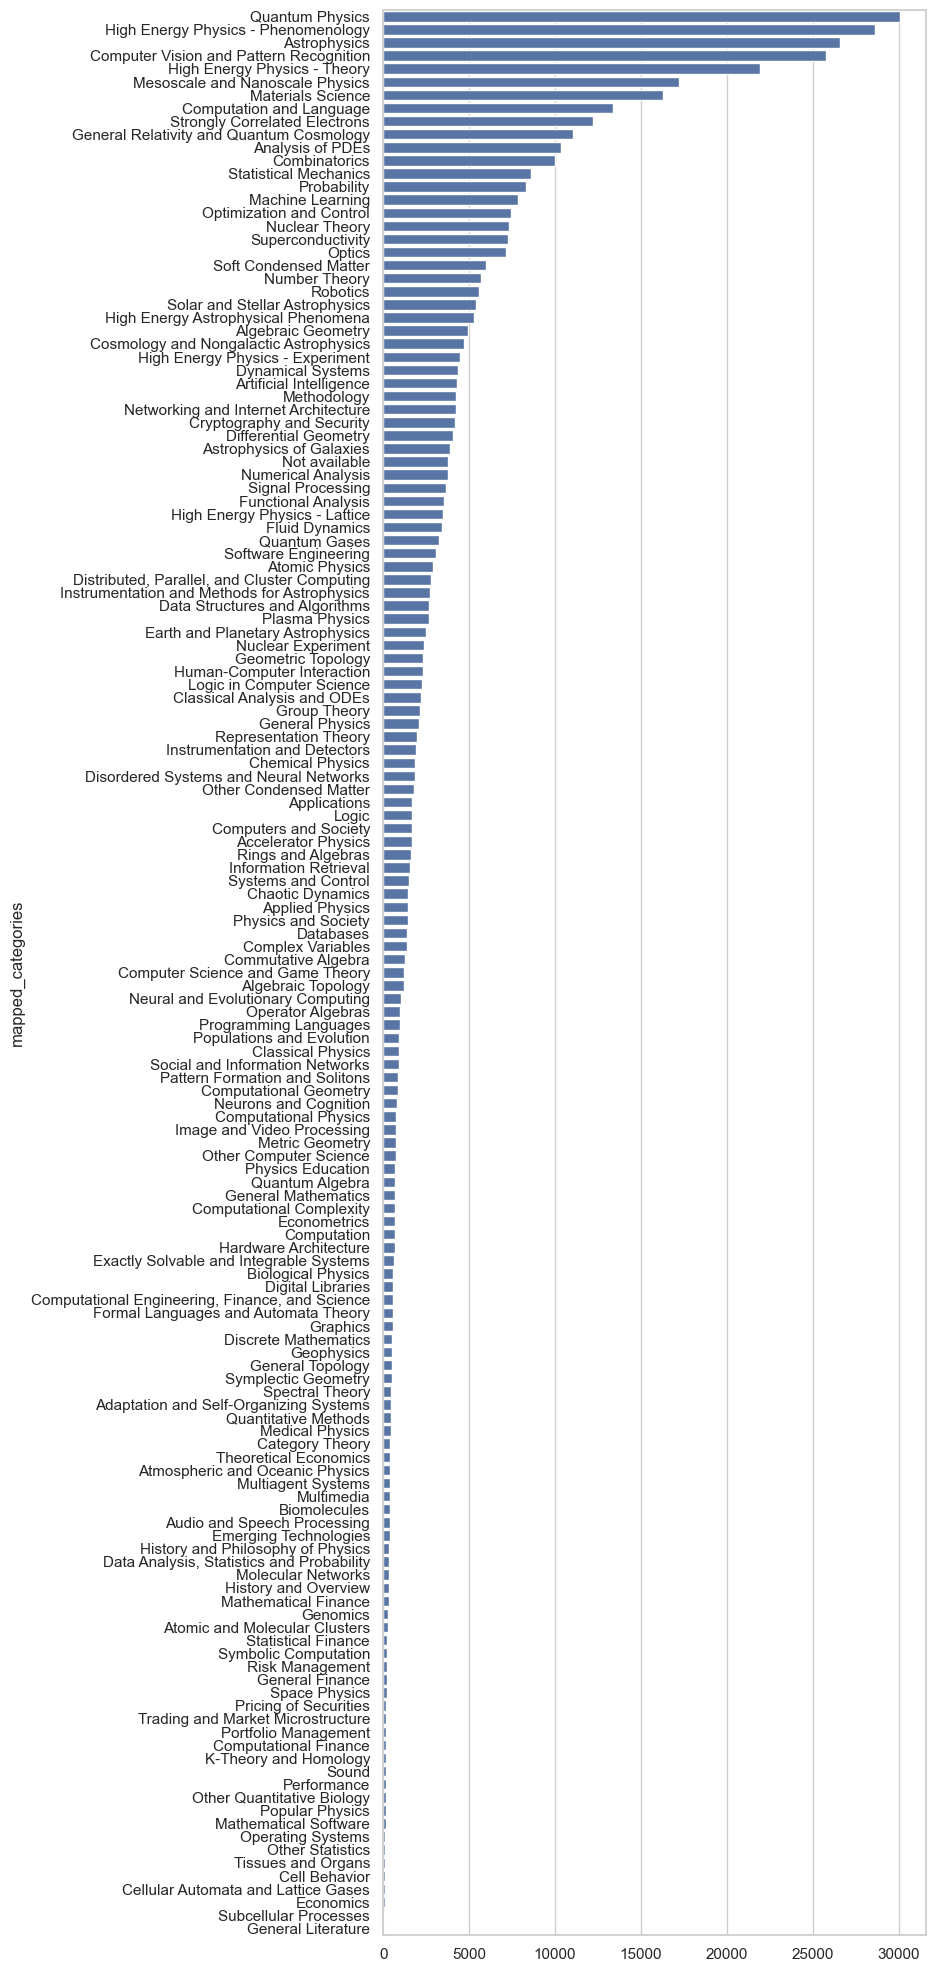

In [62]:
plot_category_counts(data_clean_simple_df)

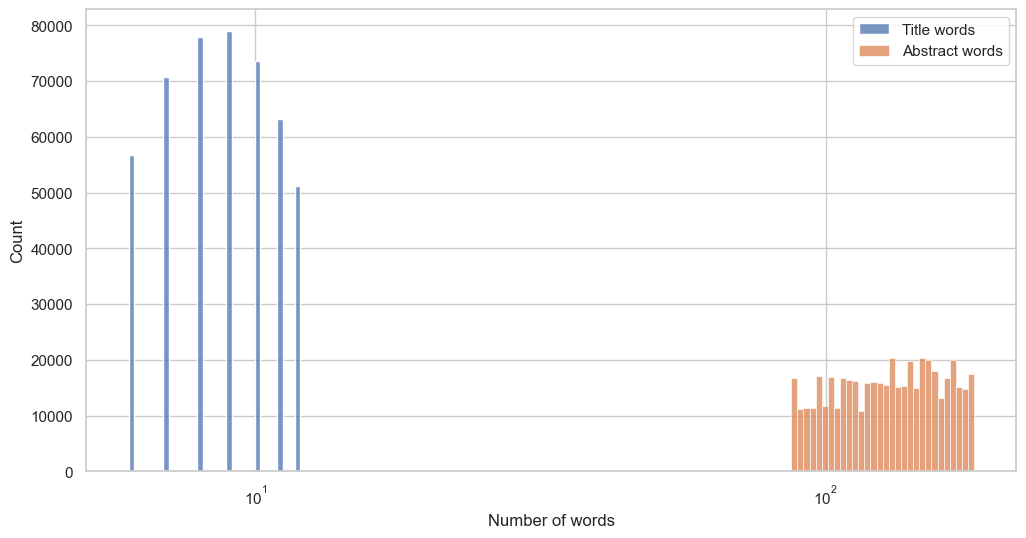

In [63]:
# Now again have a look at the distribution of the number of words in the abstracts and titles
plt.figure(figsize=(12, 6))
_ = sns.histplot(data_clean_simple_df['title_words'], bins=30, log_scale=True, label='Title words')
_ = sns.histplot(data_clean_simple_df['abstract_words'], bins=30, log_scale=True, label='Abstract words')
plt.legend()
plt.xlabel('Number of words')
plt.show()

In [64]:
# Finally, remove papers with less common categories (less than 1000 papers in that category)
lb_papers = 5000
category_counts = data_clean_simple_df['mapped_categories'].explode().value_counts().sort_values(ascending=False)
print(f"Total categories: {len(category_counts)}")
data_clean_simple_final_df = data_clean_simple_df[
    data_clean_simple_df['mapped_categories'].apply(lambda x: category_counts[x[0]] >= lb_papers)
].reset_index(drop=True)
print(f"Papers before cleaning: {len(data_clean_simple_df)}")
print(f"Papers after cleaning: {len(data_clean_simple_final_df)}")

Total categories: 147
Papers before cleaning: 472237
Papers after cleaning: 305306


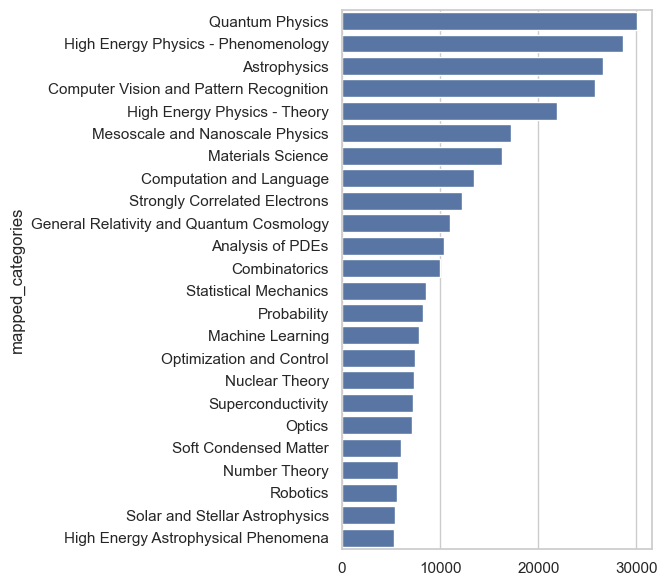

In [65]:
plot_category_counts(data_clean_simple_final_df, fig_size=(4, 7))

In [66]:
final_classes = data_clean_simple_final_df['mapped_categories'].explode().unique().tolist()
print(f"Final classes: {len(final_classes)}")
print(final_classes)

Final classes: 24
['High Energy Physics - Phenomenology', 'Mesoscale and Nanoscale Physics', 'General Relativity and Quantum Cosmology', 'Materials Science', 'Combinatorics', 'Number Theory', 'Strongly Correlated Electrons', 'High Energy Physics - Theory', 'Probability', 'Optics', 'Quantum Physics', 'Superconductivity', 'Astrophysics', 'Nuclear Theory', 'Statistical Mechanics', 'Soft Condensed Matter', 'Analysis of PDEs', 'Optimization and Control', 'Computer Vision and Pattern Recognition', 'Robotics', 'Machine Learning', 'Computation and Language', 'Solar and Stellar Astrophysics', 'High Energy Astrophysical Phenomena']


In [25]:
n_samples = 100_000
categories_of_interest = []
if len(categories_of_interest) == 0:
    sampled_df = data_clean_simple_final_df.copy()
else:
    sampled_df = data_clean_simple_final_df[data_clean_simple_final_df['mapped_categories'].apply(lambda x: x[0] in categories_of_interest)]

sampled_df = sampled_df.sample(n_samples, random_state=42).reset_index(drop=True)

# samples_per_category = n_samples // len(category_map.values())
# print(f"Sampling {samples_per_category} papers per category for {n_samples} samples")

# sampled_data = []
# for cat, count in category_counts.items():
#     if count < samples_per_category:
#         sampled_data.append(data_clean_simple_final_df[data_clean_simple_final_df['mapped_categories'].apply(lambda x: cat in x)])
#     else:
#         sampled_data.append(data_clean_simple_final_df[data_clean_simple_final_df['mapped_categories'].apply(lambda x: cat in x)].sample(samples_per_category, random_state=42))
# sampled_df = pd.concat(sampled_data).sample(frac=1, random_state=42).reset_index(drop=True)

In [26]:
sampled_df.head(3)

,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year
0,1807.07312,Spin-wave amplification and lasing driven by i...,We show that an inhomogeneity in the spin-tr...,[cond-mat.mes-hall],2019-01-30,10,103,[Mesoscale and Nanoscale Physics],1,2019
1,1805.11914,Massive spin 2 excitations in $AdS_6\times S^2...,We study (massive) spin-2 fluctuations aroun...,[hep-th],2018-08-15,9,92,[High Energy Physics - Theory],1,2018
2,2112.03461,GraphPAS: Parallel Architecture Search for Gra...,Graph neural architecture search has receive...,[cs.LG],2021-12-08,8,115,[Machine Learning],1,2021


In [27]:
def text_processing(sample):
    title = sample['title']
    abstract = sample['abstract']

    # remove special characters
    title = title.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    abstract = abstract.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')

    # remove multiple spaces
    title = ' '.join(title.split())
    abstract = ' '.join(abstract.split())

    return f"Title: {title} - Abstract: {abstract}"

In [28]:
sampled_df['text'] = sampled_df.apply(text_processing, axis=1)

In [29]:
# show 3 examples
for i, row in sampled_df.sample(3).reset_index().iterrows():
    print(f"Example {i + 1}")
    print(row['text'])
    print("-" * 50)

Example 1
Title: AdS plane waves, entanglement and mutual information - Abstract: $AdS$ plane wave backgrounds are dual to CFT excited states with energy momentum density $T_{++}=Q$. Building on previous work on entanglement entropy in these and nonconformal brane plane wave backgrounds, we first describe a phenomenological scaling picture for entanglement in terms of "entangling partons". We then study aspects of holographic mutual information in these backgrounds for two strip shaped subsystems, aligned parallel or orthogonal to the flux. We focus on the wide ($Ql^d\gg 1$) and narrow ($Ql^d\ll 1$) strip regimes. In the wide strip regime, mutual information exhibits growth with the individual strip sizes and a disentangling transition as the separation between the strips increases, whose behaviour is distinct from the ground and thermal states. In the narrow strip case, our calculations have parallels with "entanglement thermodynamics" for these $AdS$ plane wave deformations. We also 

## Model Exploration

### all-MiniLM-L6-v2

In [113]:
import chromadb
from chromadb.utils import embedding_functions

CHROMA_DATA_PATH = "chroma_data/"
EMBED_MODEL = "all-MiniLM-L6-v2"
# EMBED_MODEL = "all-mpnet-base-v2"
COLLECTION_NAME = "arxiv_papers"
batch_size = 5000

CHROMA_DATA_PATH = os.path.join(CHROMA_DATA_PATH, EMBED_MODEL)

# delete the collection if it exists
client = chromadb.PersistentClient(path=CHROMA_DATA_PATH)

embedding_func = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name=EMBED_MODEL,
    device="cuda",
)

collection = client.create_collection(
    name=COLLECTION_NAME,
    embedding_function=embedding_func,
    metadata={"hnsw:space": "cosine"},
    get_or_create=True,
)

# get all the ids from the collection
response = collection.get()
print(f"Collection has {len(response['ids'])} ids")

# reset the collection
if len(response['ids']) > 0:
    for i in tqdm(range(0, len(response['ids']), batch_size)):
        collection.delete(ids=response['ids'][i:i + batch_size])

Collection has 10000 ids


  0%|          | 0/2 [00:00<?, ?it/s]

In [114]:
metadatas = []
for categories in sampled_df['mapped_categories']:
    metadata = {f"category_{i}": category for i, category in enumerate(categories)}
    metadatas.append(metadata)

for i in tqdm(range(0, len(sampled_df), batch_size)):
    collection.add(
        documents=sampled_df['text'].iloc[i:i + batch_size].tolist(),
        ids=sampled_df['id'].iloc[i:i + batch_size].tolist(),
        metadatas=metadatas[i:i + batch_size],
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [123]:
# Define query
words_per_line = 10
# define papers to show
top_n_papers = 3
query = "Black holes in the universe and suns in the galaxy"
print("Query:\n", query, "\n")
query_results = collection.query(query_texts=[query], n_results=top_n_papers)
for _id, _doc, _dist, _meta in zip(query_results["ids"][0], query_results["documents"][0], query_results["distances"][0], query_results["metadatas"][0]):
    print(f"#####   ID: {_id}   #####")
    print(f"Distance: {_dist}")
    print(f"Metadata: {_meta}")
    _doc_lines = _doc.split()
    for i in range(0, len(_doc_lines), words_per_line):
        print(" ".join(_doc_lines[i:i + words_per_line]))
    print("\n")

Query:
 Black holes in the universe and suns in the galaxy 

#####   ID: astro-ph/9712076   #####
Distance: 0.32183510065078735
Metadata: {'category_0': 'Astrophysics'}
Title: Relics of Nuclear Activity: do all galaxies have massive
black holes? - Abstract: The distribution of black hole masses
in galaxies is constrained by photometric and kinematic studies of
individual galaxies, and by the properties of the quasar population.
I review our understanding of these topics, present new results
of adiabatic black hole growth models for HST photometry of
elliptical galaxies with brightness profiles of the `core' type, and
discuss the implications of ground-based stellar kinematical data. It is
not yet possible to uniquely determine the black hole mass
distribution, but the available evidence is not inconsistent with a
picture in which: (i) a majority of galaxies has black
holes; (ii) there is a correlation (with large scatter) between
black holes mass M_BH and spheroid luminosity L_sph, app

In [118]:
response = collection.get(include=["metadatas", "documents", "embeddings"])
df = pd.DataFrame({
    "id": response["ids"],
    "document": response["documents"],
    "embedding": response["embeddings"],
    "categories": [list(m.values()) for m in response["metadatas"]],
})
all_categories = df["categories"].explode().unique()
df["first_category"] = df["categories"].apply(lambda x: x[0])
df.loc[:, all_categories] = df["categories"].apply(lambda x: [1 if cat in x else 0 for cat in all_categories]).tolist()
df.head(3)

,id,document,embedding,categories,first_category,Mesoscale and Nanoscale Physics,Solar and Stellar Astrophysics,High Energy Physics - Phenomenology,Quantum Physics,Combinatorics,...,Number Theory,Soft Condensed Matter,Statistical Mechanics,Optimization and Control,High Energy Astrophysical Phenomena,Probability,Computer Vision and Pattern Recognition,Computation and Language,Robotics,Astrophysics
0,1001.0011,Title: Guided plasmons in graphene p-n junctio...,"[-0.007243528496474028, 0.0445939339697361, 0....",[Mesoscale and Nanoscale Physics],Mesoscale and Nanoscale Physics,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001.0032,Title: Asteroseismic Investigation of Known Pl...,"[-0.026071084663271904, -0.016712311655282974,...",[Solar and Stellar Astrophysics],Solar and Stellar Astrophysics,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1001.0045,Title: Axial Anomaly and Mixing Parameters of ...,"[-0.05569653958082199, -0.07139628380537033, 0...",[High Energy Physics - Phenomenology],High Energy Physics - Phenomenology,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
from renumics import spotlight

spotlight.show(df)

## Alibaba-NLP/gte-en-v1.5

In [ ]:
model_path = 'Alibaba-NLP/gte-large-en-v1.5'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_dtype = torch.float16 if device == 'cuda' else torch.float32
tokenizer = AutoTokenizer.from_pretrained(model_path, cache_dir=cache_dir)
model = AutoModel.from_pretrained(model_path, trust_remote_code=True, cache_dir=cache_dir)

model = model.to(device).eval().half() if torch_dtype == torch.float16 else model.to(device).eval()

In [ ]:
batch_size = 64
num_samples = 20_000

samples = df.sample(num_samples)
sample_abstracts = samples['abstract'].tolist()
sample_titles = samples['title'].tolist()

# sample_texts = [f'Title: {title.strip()} Abstract: {abstract.strip()}'.strip().replace('\n', ' ') for title, abstract in zip(sample_titles, sample_abstracts)]
sample_texts = [f'Title: {title.strip()}'.strip().replace('\n', ' ') for title, abstract in zip(sample_titles, sample_abstracts)]

In [ ]:
text_embeddings = []

for i in tqdm(range(0, num_samples, batch_size)):
    batch = sample_texts[i:i + batch_size]
    inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=8192)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0].detach().to('cpu').float()
    embeddings = F.normalize(embeddings, p=2, dim=1)
    text_embeddings.append(embeddings)

text_embeddings = torch.cat(text_embeddings).cpu().numpy()
print(text_embeddings.shape)

In [ ]:
# take random sample of text (and corresponding embeddings) and calculate cosine similarity to all other text embeddings
# show the top 3 most similar text embeddings and their corresponding text and the 3 least similar text embeddings and their corresponding text
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
sample_idx = np.random.randint(0, num_samples)
sample_embedding = text_embeddings[sample_idx]
sample_text = sample_texts[sample_idx]
print(sample_text)

cosine_similarities = text_embeddings @ sample_embedding
sorted_indices = np.argsort(cosine_similarities)

print('Most similar')
for idx in sorted_indices[-4:-1]:
    print(sample_texts[idx], cosine_similarities[idx])

print('\nLeast similar')
for idx in sorted_indices[:3]:
    print(sample_texts[idx], cosine_similarities[idx])

In [ ]:
input_text = "Machine learning for computer vision"
tokenized_input = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True, max_length=8192)
tokenized_input = {k: v.to(device) for k, v in tokenized_input.items()}
with torch.no_grad():
    output = model(**tokenized_input)
embedding = output.last_hidden_state[:, 0].detach().to('cpu').float()
embedding = F.normalize(embedding, p=2, dim=1).squeeze()

cosine_similarities = text_embeddings @ embedding.numpy()

sorted_indices = np.argsort(cosine_similarities)
print('Most similar')
for idx in sorted_indices[-4:-1]:
    print(sample_texts[idx], cosine_similarities[idx])

print('\nLeast similar')
for idx in sorted_indices[:3]:
    print(sample_texts[idx], cosine_similarities[idx])

In [ ]:
# create a interactive graph with all the text embeddings using TSNE and on hover show the text
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
from sklearn.manifold import TSNE

print('Calculating TSNE embeddings')
tsne = TSNE(n_components=2, perplexity=50, n_iter=1500, random_state=42)
tsne_embeddings = tsne.fit_transform(text_embeddings)

In [ ]:
from bokeh.models import ColumnDataSource, HoverTool, PanTool, WheelZoomTool
from bokeh.palettes import Category10
from bokeh.plotting import figure, output_notebook, show

# Prepare the data source
source = ColumnDataSource(data=dict(
    x=tsne_embeddings[:, 0],
    y=tsne_embeddings[:, 1],
    text=sample_texts
))

# Define hover tool
hover = HoverTool(tooltips=[("Text", "@text")])

# Create the plot
plot_title = "Text Embeddings"
plot_width = 800
plot_height = 600
p = figure(tools=[hover, WheelZoomTool(), PanTool()], title=plot_title, width=plot_width, height=plot_height)
p.circle('x', 'y', size=8, source=source, color=Category10[10][0], alpha=0.8, legend_label="Text Embeddings")

# Customize plot appearance
p.title.text_font_size = "16pt"
p.xaxis.axis_label = "TSNE Dimension 1"
p.yaxis.axis_label = "TSNE Dimension 2"
p.xaxis.axis_label_text_font_size = "14pt"
p.yaxis.axis_label_text_font_size = "14pt"
p.xaxis.major_label_text_font_size = "12pt"
p.yaxis.major_label_text_font_size = "12pt"
p.legend.label_text_font_size = "12pt"
p.legend.location = "top_right"
p.legend.click_policy = "hide"

# Show the plot in the notebook
output_notebook()
show(p)